<a href="https://colab.research.google.com/github/3minuterecord/myJup/blob/master/MTG_GPT_2_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning GPT-2 for Safety Incident Narrative Generation.

Use [PyTorch](https://pytorch.org/) and Transformers from [Hugging Face](https://huggingface.co/) to fine tune a [GPT-2 Model](https://openai.com/blog/gpt-2-1-5b-release/) to fabricate incident descriptions.

Code chunk references:
- [Rey Farhan](http://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/)
- [Chris McCormick's](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) BERT fine-tuning tutorial
- [Ian Porter's](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) GPT2 tutorial 
- [Hugging Face](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) Language model fine-tuning script.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup

- Start by installing the Huggingface transformers library. 
- Installing transformers will also install tokenizers (a dependency and another useful set of tools for this task).

In [1]:
%%capture
!pip install transformers

In [2]:
import pandas as pd

In [3]:
#sample_name = 'site compliance or practice issue_222_out_df_temp'
sample_name = 'hydraulic fluid or oil leak_577_out_df_temp'
reports = pd.read_csv(f"/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/language_models/training_data/{sample_name}.csv", dtype=str)  

In [4]:
reports = reports[reports.category != '*** Not Classified']
reports = reports[['text']]
#reports = reports['text'].tolist()
reports = reports['text']
reports

2        robodrill spider excavator being operated when...
17       spill to grade from grader pp103 at wpb angore...
24       fuel (red diesel) spilled onto whiterock/dirt ...
46       oil leak from crane that was on site for plann...
82       minor spill to grade (1 liter) from cat front ...
                               ...                        
90259    struck by discharged object or substance an em...
90458    injured by slipping or swinging object held by...
90618    struck by swinging part of powered vehicle an ...
91361    caught in running equipment or machinery durin...
92074    struck against object or equipment, unspecifie...
Name: text, Length: 577, dtype: object

In [5]:
# Print an example as a spot check
reports.iloc[4]

'minor spill to grade (1 liter) from cat front loader at moro x what happened:~1340hrsthe cat 938 front loader was loading backfilling materials inside the moro x camp. at the stockpile area, the operator loaded a bucket of backfill material and was signaled by his spotter to back the machine and drive out. as the machine reversed, the spotter noticed the red liquid spraying out from the back of the bucket. upon realizing, the spotter signaled the operator to stop and the machine was stopped immediately. the quick action by the spotter, grabbing the spill containing materials inside the spill kit provided on site, mitigated and contained the spill estimated at 1 liter of hyd fluid. drip tray was placed underneath the leaking hydraulic hose to fetch the leaking oil from the system. all contaminated materials, absorbent pads, organic oil absorbent and the soil scrubbed off, disposed appropriately into the contaminated waste bag provided.a closer look revealed that the hydraulic hose that

# Load a Training Set

Use small subset datasets created from rule-book classification step. 


# GPT2 Tokenizer

First a brief description of tokenization straight from the source, the Hugging Face [Tokenizers](https://github.com/huggingface/tokenizers) github page:

```
What is a Tokenizer

A Tokenizer works as a pipeline, it processes some raw text as input and outputs an Encoding. The various steps of the pipeline are:

- The Normalizer: in charge of normalizing the text. Common examples of normalization are the unicode normalization standards, such as NFD or NFKC.
- The PreTokenizer: in charge of creating initial words splits in the text. The most common way of splitting text is simply on whitespace.
- The Model: in charge of doing the actual tokenization. An example of a Model would be BPE or WordPiece.
- The PostProcessor: in charge of post-processing the Encoding to add anything relevant that, for example, a language model would need, such as special tokens.
```

We will be using the GPT-2 tokenizer to tokenize our flavor text data. The defaults of this function set the bos (beginning of sentence) eos (end of sentence) to '<|endoftext|>' but we can specifically set them differently to differentiate and also assign a non-default pad token that will take care of white space for differently sized text. The next cell will instantiate our tokenizer and provide an example encoding.

In [6]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')


tokenizer.encode("Sample Text")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[36674, 8255]

From the example above we can see that the example string is encoded by the GPT2 tokenizer to a list of numerical values that represent the string, in this case one value per word. These values are easier to train the neural network model on than the string representation. We now have a corpus of flavour text we can iterate through, and a tokenizer, we should quickly inspect it to see what the longest string is, this will be useful later when we need to know how long to pad our sentences out to.


In [7]:
max_report = max([len(tokenizer.encode(report)) for report in reports])

print(f'The longest report text is {max_report} tokens long.')

The longest report text is 878 tokens long.


# PyTorch Datasets & Dataloaders


Different language models require different amounts of memory to hold all of the weights and biases in memory. Based on the memory your machine has available this will determine how you set your batch size. If your instance is running on a T4 GPU you can set batch to 32, but you may have to scale down if allocated a less powerful instance. 

In [8]:
!nvidia-smi

Thu Aug 11 08:03:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
bs = 1

The batch size will affect the training time so it is always a good idea to set the batch to the highest number you can fit in the memory of the GPU you are using for training, however this hyper parameter should only affect training time but not model performance. A batch size too large won't fit in memory for some GPUS so you will have to adjust this parameter if you aren't allocated a T4 or K80.

The next thing to do is to create a custom dataloader for our corpus, we will follow the [PyTorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) documentation on this to create ```MTGDataset```.

In [10]:
import torch
torch.manual_seed(42)
from torch.utils.data import Dataset # this is the pytorch class import

class safety_dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=max_report):

    self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      """
      This loop will iterate through each entry in the flavour text corpus.
      For each bit of text it will prepend it with the start of text token,
      then append the end of text token and pad to the maximum length with the 
      pad token. 
      """

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                 truncation=True, 
                                 max_length=max_length, 
                                 padding="max_length")
      
      """
      Each iteration then appends either the encoded tensor to a list,
      or the attention mask for that encoding to a list. The attention mask is
      a binary list of 1's or 0's which determine whether the langauge model
      should take that token into consideration or not. 
      """
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

The maximum length of tokens is 768, however we don't need to use this length as we saw that the longest string we are encoding is only 98 words long. So to save space in the model we will only pad up to the longest string in our corpus and not the longest string the tokenizer can handle. Next we will create the dataset itself using this class. Like I described above in the code each entry in the dataset will be two tensors, one which is the encoding for the string and one which is the attention mask. This dataset will then be split into the training and validation sets.


In [11]:
from torch.utils.data import random_split

dataset = safety_dataset(reports, tokenizer, max_length=max_report)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {train_size} samples for training, and {val_size} samples for validation testing'

'There are 519 samples for training, and 58 samples for validation testing'

Finally to illustrate what an entry in this dataset looks like below is a print out of the first encoded string. You can see that for every encoded word the model pays attention to we have a 1, then for the padding encodings (50258) we have a 0.

In [12]:
dataset[0]

(tensor([50257, 22609,   375, 20190, 19230, 22659,  1352,   852, 12228,   618,
         31489, 15830,  4054,   290,  2716,  1160,  4029,   286,  7409, 11711,
           284,  9559,   379,  6702,   838,    25,  1314,   319,   262,  2681,
           400,   286,   730,    65,   257, 34797, 31489, 15830,  4054,   290,
          2716,  1160,  4029,   286,  7409, 11711,   284,  9559,   319,   262,
          3857,   375, 20190, 19230, 22659,  1352,   379,   479,    79,    21,
            13,    19,   319,   262,  5752,   477, 23543,  5696,    11, 17565,
           298, 21226,    11,   547, 29947,   286, 20431,   656,   262, 23543,
          7030, 11668,    13, 50256, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 5

Next we will create the dataloader object which will feed the neural network, this combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset, see the official [documentation](https://pytorch.org/docs/1.1.0/_modules/torch/utils/data/dataloader.html) for further details. 

In [13]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = bs
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Sampling for validation is sequential as the order doesn't matter.
            batch_size = bs 
        )

# Finetune GPT2 Language Model

In [14]:
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [15]:
# We wil create a few variables to define the training parameters of the model
# epochs are the training rounds
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs = 4
warmup_steps = 1e2
sample_every = 100

[AdamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) is the optimizer of choice for training many models, we will be using [Hugging Face's](https://huggingface.co/transformers/main_classes/optimizer_schedules.html) implementation and all of it's defaults, we will also set the number of epochs here, again as we are fine tuning, not retraining, we don't need to run very long models. 

In [16]:
from transformers import AdamW
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [17]:
from transformers import get_linear_schedule_with_warmup

"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""

total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [34]:
torch.cuda.empty_cache()

In [18]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.5 GB
Cached:    0.5 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:393: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [19]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 519. Loss:0.7682449817657471. Time:0:00:19
Example output:  bipartisan-welfare-crisis-crisis-welfare-crisis-welfare-crisp-on-the-side-of-a-riggings-a-small-house-car-dishes on a cairs, with a cairs.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 519. Loss:0.18608418107032776. Time:0:00:38
Example output:  increasingcope incident severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating rating severity rating severity rating rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating severity rating rating severity rating severity rating severity rating severity rating rating severity rating severity rating rating severity rating severity rating rating severity rat

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 519. Loss:0.34021487832069397. Time:0:00:58
Example output: daythe operator struck the truck by hydraulic fluid leak, resulting in approximately 8l of hydraulic fluid leaking from the boom. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 519. Loss:0.08749598264694214. Time:0:01:16
Example output:  Hangoil leak from the hydraulic line, contaminating material to grade.  spill response team immediately contacted site.  spill investigation began and spill response protocols were initiated.  spill was estimated at approximately 1l (3-6l) to grade.  spill response team has placed a seal on the leak and removed contaminated material and returned it to site.  spill is estimated to have been 100ml (0.5l) to grade at the scene at the time of the incident.  spill response team will continue to assess the source and source of the spill.  safety procedures have been initiated. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 519. Loss:0.37565290927886963. Time:0:01:35
Example output:  foodsd.g. of sand (approx. 200ml) on the mewp runway. the runway manager contacted the mewp inspector to assess the issue.
Average Training Loss: 1.1208244778919312. Epoch time: 0:01:39
Validation loss: 0.5278711475688835. Validation Time: 0:00:03
Beginning epoch 2 of 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 519. Loss:0.4834175705909729. Time:0:00:18
Example output:  trailhgcp500 wpa hydraulic system suffered an oil spill from a hydraulic tank of ptp500 on kp11 in a gravel hdds located near the ewp.  approximately 5 gallons migrated from legacy cairs incident #3637hgcp500 wpa hydraulic system suffered an oil spill from a hydraulic tank of ptp500 on kp11 in a gravel hdds located near the ewp.  approximately 5 gallons migrated from legacy cairs - see detailed description


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 519. Loss:0.5898421406745911. Time:0:00:37
Example output: intends trencher (a rented tractor) has been rented out for a quick work change in the front yard.  the rental company has no evidence that a leak had reached surface.  this rental company does not work and we did not obtain any evidence that a leak had reached surface.  when we contacted the rental company it stated that there was no leak and no signs of internal corrosion.  we could not find a fault or the client was informed about it.  the rental company stated that it did not take any photographs when the rental truck arrived. we found that the rental truck had been rented out of the parking lot for a quick work change.  there was no evidence of internal corrosion from the rental truck and the rental company stated that the rental truck had had no leaks from outside the front yard. we do not find any evidence of internal corrosion from the rental truck. the rental truck company did not take any photographs when

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 519. Loss:0.2533373534679413. Time:0:00:57
Example output:  surroundthe operator was moving rocks on a metal pallet, when he heard a loud bang, an oil leak, and a pop sound.  he called the operator. the operator shut down the pallet to inspect the leak and was notified.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 519. Loss:0.09786997735500336. Time:0:01:16
Example output:  reflexinjured another employee during an effort to remove a pin in the hydraulic lift of an excavator it occurred to the operator that he had placed one of the hydraulic hoses under the pump of an excavator to push hydraulic fluid out. the hose fell, causing approximately 150-300ml of hydraulic fluid to spray onto the wider environment. the hose also contained a substance.  contaminated material removed from site.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 519. Loss:0.4947625696659088. Time:0:01:35
Example output:  display4x4" burst hydraulic line failed causing <5 litters of hydraulic fluid to spill from the excavator onto the ground at kansas general contractor site at around 9:00 am. the operator received a hydraulic hose fitting on the ground causing <5 litters of hydraulic fluid to spill from the excavator onto the ground at kansas general contractor site at around 9:00 am.  the operator went to the site and isolated hydraulic hose fittings, inspected and cleaned up and cleaned the damaged pipe and placed the remainder of the absorbent wipes in place.  after the investigation it was determined that the leak was caused due to the hydraulic hose fitting issue. the spill was cleaned up and disposed of by the operator and the client of the excavator contractor. 
Average Training Loss: 0.4750134371838358. Epoch time: 0:01:40
Validation loss: 0.5015801082140413. Validation Time: 0:00:03
Beginning epoch 3 of 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 519. Loss:0.4962204098701477. Time:0:00:18
Example output:  pastorthe operator experienced a hydraulic hose failure on the rear rack after leaving the machine for an oil check at dow h. the operator asked for assistance with hydraulic fluid drops. the operator was then transported to the burn hospital where he was treated for a minor hydraulic hose failure.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 519. Loss:0.24403877556324005. Time:0:00:37
Example output:  illicita third party owned asset was identified leaking hydraulic oil onto the ground. at approximately 11:30am, a third party owned asset -  what appears to be an air compressor leak -  was identified leaking hydraulic oil onto the ground.  oil released was approximately 50ml from the air compressor. during this initial investigation   the third party owned asset was identified leaking from the bottom line of the unit as well as from inside the unit and in one corner of the compartment.  leaked hose was slightly cracked, so that the hose plug connector on the first two plug plug boxes would not fit the hose plug properly on the second unit. migrated from legacy cairs incident #39877hummingbird pp114 incident #39878brazos pcs114 - note note: this unit was used in a pilot air compressor and was subsequently fitted with the air compressors third party owned asset was identified leaking hydraulic oil onto the ground

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 519. Loss:0.8116185665130615. Time:0:00:57
Example output:  Liberationa mini nacap crane suffered a hydraulic failure. it was identified that a hydraulic leak in the hydraulic hose of the mini nacap. the crane was immediately taken out of service and returned to operations.   mechanic was able to identify a failed oil reservoir located inside the mini nacap deck. the hydraulic hose of the mini nacap was replaced. migrated from legacy cairs incident #33543on tuesday, april 22, 2016 at 12:00 pm at cordon dt the dow freeport a mini nacap crane suffered a hydraulic failure on the crane. the hydraulic hose of the mini nacap was replaced. mechanic was able to identify a failed oil reservoir located inside the mini nacap deck. the hydraulic hose of the mini nacap was replaced. mechanic was able to identify a failed oil reservoir located inside the mini nacap. the hydraulic hose of the mini nacap was replaced. mechanic was able to identify a failed oil


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 519. Loss:0.5690640807151794. Time:0:01:17
Example output:  Nama hydraulic oil spill was traced to a leak from a pump located on the row after a hydraulic oil tanker was moving to clear the row (the row was isolated for the final phase in the planned e-mileage programme). the spill was immediately detected with the spill kit and deployed immediately. the spill has been identified with the spill trays and bunds that were put up to catch the oil.  the oil has also been put on the ground and placed on the concrete paving.  further action will be required to control and contain the spill.  a local pollution control centre will have to clean up any contaminated soil and will need to identify the source of the spill and whether or not to use it to feed the wider environment.  all affected area will be secured with appropriate response equipment and contaminated material utilised for disposal.  area:1.6" x 1.6" x 1.6" woodland area with well pad facilities. spill location: block 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 519. Loss:0.1823292374610901. Time:0:01:38
Example output: IONa cajun excavator working on paving road, working at approximately 9:00am on paving road, discovered a small amount of limestone that appeared to have been disturbed by flowing water.  no water courses were found in the roadway during the investigation. a local foreman was present at the excavation area and assisted by a fitter.  excavator had experienced a hydraulic leak. a spill was reported immediately by the fitter to the supervisor and the fitter sent a swab bag to contain any contaminated soil and returned to the site for disposal.
Average Training Loss: 0.39826501051039365. Epoch time: 0:01:42
Validation loss: 0.49911968499935905. Validation Time: 0:00:03
Beginning epoch 4 of 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 519. Loss:0.16387569904327393. Time:0:00:18
Example output:  glimpsehydraulic hose burst on excavator causing oil spill. migrated from legacy cairs incident #32342on october 16, 2016 at approximately 09:30am the operator of the excavator excavating for the daily light rail tunnel access road observed a burst hydraulic hose on a hydraulic fitting on a hydraulic boom resulting in a spill of approximately 3 gallons of hydraulic oil onto the ground. operator immediately deployed absorbent material in place to clean up and notified supervisor. investigation initiated migrated from legacy cairs - see detailed description


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 519. Loss:0.05875977501273155. Time:0:00:37
Example output:  Laurehydraulic hose burst on excavator  approximately 1 pint of hyd fluid leaked from excavator onto soil.  approx 1 pint was spilt to soil. leak contained utilizing a spill kit. migrated from legacy cairs incident #36427what happened:hydraulic hose burst on excavator ~1 pint of hyd fluid leaked from excavator onto soil. no injuries or ill health noted in the incident.the contaminated soil was immediately cleaned up and contaminated soil labels and absorbent pad bags were placed on excavator and removed from location. migrated from legacy cairs - see detailed description


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 519. Loss:0.4833313524723053. Time:0:00:57
Example output: isma rented aerial lift was found to be leaking hydraulic oil. on friday october 3rd, 2019 at 7:45pm at the dow freeport a rented aerial lift was found to be leaking hydraulic oil.  no oil entered any drains or drains on the freeport. migrated from legacy cairs incident #34471what happened: at approximately 11:30 am hydraulic oil on the dow freeport runway was found to have leaked out. the rental company was informed and by 7:45pm a permit was raised to clear the area and all contaminated soil was removed. migrated from legacy cairs - see detailed description


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 519. Loss:0.1420065015554428. Time:0:01:16
Example output: ouna hydraulic line fitting fitting busted on a mini pump truck.  a hose fitting on the underside of a mini pump truck busted and resulted in a burst fire hose.  the small fire that followed resulted in approximately 3 oz. of hydraulic fluid spilled to ground.  the spill was contained with contaminated materials, diapers and other forms of shelter.  spill kit used to contain the spill.  wood n.y. emergency response team responded to scene and initiated spill response.  wood personnel placed spill trays and absorbent pads on the spill area.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 519. Loss:0.8523287177085876. Time:0:01:35
Example output:  electionthe skid steer of a caterpillar was found to have leaking hydraulic oil (approximately 1l). migrated from legacy cairs incident #34562hgcp hdd pad n°404319at approximately 08:15 today on 03/04/2020 at gmb wood subcontractor, emissario dombuto had completed a pre-start inspection of the front right side of the front right track (removing / removing / crushing the hydraulic fluid), but the area has deteriorated over time due to the heavy rain / heavy winds (roughly 10-12 minutes on 31° dow). due to recent rain, there were no obvious drips on the surrounding area, indicating that the area was dry. further checks revealed that the hydraulic hose of the skid steer had split / parted / damaged causing no further leakage of hydraulic oil into the stormwater system. at approximately 17:30 am the weathercock was called and alerted.the actual severity of the incident was selected as a
Average Training Loss: 0.335395

Let's view the summary of the training process, We'll visualize the change in training and validation loss to see if the models is converging. 

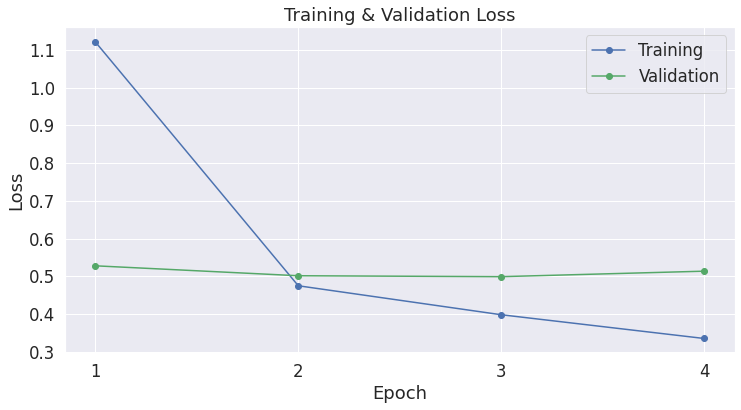

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Saving & Loading Fine-Tuned Model

Next it is a good idea to move the model we have trained and the associated weights, biases and model parameters out of the Colab space and into our own google drives. The cell below will mount your drive for you, then you can save the model using the prebuilt Hugging Face and PyTorch functionalities.




In [23]:
def split_input(user_string, chunk_size):
    output = []
    words = user_string.split(" ")
    total_length = 0

    while (total_length < len(user_string) and len(words) > 0):
        line = []
        next_word = words[0]
        line_len = len(next_word) + 1

        while  (line_len < chunk_size) and len(words) > 0:
            words.pop(0)
            line.append(next_word)

            if (len(words) > 0):
                next_word = words[0]
                line_len += len(next_word) + 1

        line = " ".join(line)
        output.append(line)
        total_length += len(line) 

    return output

# Generate Text

Lastly the fun part! We will now generate samples from our model to test how well our model performs!

In [44]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
    fab_txt = split_input(tokenizer.decode(sample_output, skip_special_tokens=True), 80)
    for r, chunk in enumerate(fab_txt):
        if r == 0:
            head_txt = f'\nFake {i+1}:'
            print(head_txt)
            print('-'*(len(head_txt)-1))
            print(chunk)    
        else:
            print(chunk)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Fake 1:
-------
hydraulic oil spill to grade from excavator migrated from legacy cairs
incident #34092hgcp construction hdd pad (pp141) migrated from legacy cairs -
see detailed description

Fake 2:
-------
a rental crane had a hydraulic oil leak on the trailer side. the crane came
down a hydraulic oil tank. approximately 2 gallons of hydraulic oil was
released on the ground.  actual/potential based on equipment failure and
reasonable mitigation measures. the crane was not in good standing with the
trailer.  the spill was contained and cleaned up, and area cleaned. 

Fake 3:
-------
fall on same level an employee was using a hydraulic lacerated leg and was
hospitalized.


If you are familiar with MTG then you can evaluate these for yourself to determine how well the model has worked, or if you have modified the code to accept your own data input for a specific task this is what you are looking to evaluate for your own uses. Lastly, if you want to load the model you have saved to your google drive, the next cell will load the fine tuned GPT2 model and tokenizer, this means you can also share your model with other!

In [ ]:
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)